# Multi Layer Perceptron

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

PyTorch version:[2.0.1+cu118].


In [2]:
#device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("This notebook use [%s]."%(device))

This notebook use [cuda:0].


# Set hyper-parameter

In [3]:
EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 0.001

# Prepare dataset

In [4]:
# MNIST dataset
mnist_train = datasets.MNIST(root = './data/', train = True, transform = transforms.ToTensor(), download = True)
mnist_test = datasets.MNIST(root = './data/', train = False, transform = transforms.ToTensor(), download = True)

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size = BATCH_SIZE, shuffle = False, num_workers = 1)

print("Preparing dataset done!")

100%|██████████| 9912422/9912422 [00:00<00:00, 395883748.28it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43047510.24it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 137498337.84it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 20244982.75it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Preparing dataset done!


# Defining Model

In [5]:
# our model
class Model(nn.Module):

    def __init__(self, input_features = 784, hidden_size = 256, output_features = 10, init_weight = "he", init_bias = "zero"):

        super(Model, self).__init__()
        self.init_weight = init_weight
        self.init_bias = init_bias

        self.linear1 = nn.Linear(input_features, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_features)
        self.init_params()

    def init_params(self):

        init_weight_method = {
            "he" : nn.init.kaiming_normal_,
            "xavier": nn.init.xavier_normal_
        }
        assert self.init_weight in init_weight_method.keys(), f"Select the weight initialization method in {list(init_weight_method.keys())}"

        init_bias_method = {
            "zero": nn.init.zeros_,
            "uniform": nn.init.uniform_
        }
        assert self.init_bias in init_bias_method.keys(), f"Select the bias initialization method in {list(init_bias_method.keys())}"

        for param_name, param in self.named_parameters():

            if 'weight' in param_name:

                print(param)
                init_weight_method[self.init_weight](param)

            elif 'bias' in param_name:

                init_bias_method[self.init_bias](param)

    def forward(self, X):

        X = F.relu((self.linear1(X)))
        X = self.linear2(X)

        return X

In [6]:
model = Model().to(device)

Parameter containing:
tensor([[ 0.0342, -0.0007,  0.0054,  ...,  0.0009,  0.0216,  0.0035],
        [ 0.0316,  0.0286,  0.0193,  ...,  0.0168,  0.0152,  0.0081],
        [ 0.0200,  0.0282, -0.0076,  ...,  0.0262,  0.0210, -0.0308],
        ...,
        [ 0.0123,  0.0251, -0.0167,  ..., -0.0142, -0.0281,  0.0255],
        [ 0.0340, -0.0061, -0.0174,  ..., -0.0345,  0.0207,  0.0155],
        [ 0.0324, -0.0121,  0.0346,  ...,  0.0217,  0.0271,  0.0084]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0350,  0.0072, -0.0569,  ..., -0.0501,  0.0459,  0.0251],
        [-0.0517,  0.0624, -0.0204,  ...,  0.0586,  0.0171, -0.0245],
        [-0.0476,  0.0234,  0.0130,  ...,  0.0233,  0.0131,  0.0271],
        ...,
        [-0.0419,  0.0105,  0.0227,  ...,  0.0123, -0.0234, -0.0376],
        [-0.0077, -0.0457,  0.0123,  ..., -0.0399,  0.0021,  0.0294],
        [-0.0069, -0.0222,  0.0013,  ..., -0.0175,  0.0218, -0.0580]],
       requires_grad=True)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [8]:
total_params = 0

for param_name, param in model.named_parameters():

    if param.requires_grad:

        total_params += len(param.reshape(-1))

print(f"Number of Total Parameters: {total_params:,d}")

Number of Total Parameters: 203,530


# Define help function

In [9]:
def test_eval(model, data_iter, batch_size):

    with torch.no_grad():

        test_loss = 0
        total = 0
        correct = 0
        for batch_img, batch_lab in data_iter:

            X = batch_img.view(-1, 28*28).to(device)
            Y = batch_lab.to(device)

            y_pred = model(X)

            _, predicted = torch.max(y_pred.data, 1)

            correct += (predicted == Y).sum().item()

            total += batch_img.size(0)

        val_acc = (100 * correct / total)

    return val_acc

# Train MLP Model

In [10]:
# Training Phase

#model.train()

print_every = 1
print("Start training!")
# Training loop
for epoch in range(EPOCHS):

    loss_val_sum = 0

    for batch_img, batch_lab in train_iter:

        X = batch_img.view(-1, 28*28).to(device)
        Y = batch_lab.to(device)

        #Inference & Calculate loss
        y_pred = model.forward(X)
        loss = criterion(y_pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_val_sum += loss

    if ((epoch % print_every) == 0) or (epoch == (EPOCHS - 1)):

        loss_val_avg = loss_val_sum / len(train_iter)
        accr_val = test_eval(model, test_iter, BATCH_SIZE)
        print(f"epoch: [{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracy:[{accr_val:.3f}]")

print("Training Done!")

Start training!
epoch: [1/10] cost:[0.376] test_accuracy:[94.290]
epoch: [2/10] cost:[0.162] test_accuracy:[96.110]
epoch: [3/10] cost:[0.115] test_accuracy:[96.720]
epoch: [4/10] cost:[0.087] test_accuracy:[97.160]
epoch: [5/10] cost:[0.068] test_accuracy:[97.420]
epoch: [6/10] cost:[0.056] test_accuracy:[97.390]
epoch: [7/10] cost:[0.047] test_accuracy:[97.480]
epoch: [8/10] cost:[0.039] test_accuracy:[97.740]
epoch: [9/10] cost:[0.032] test_accuracy:[97.810]
epoch: [10/10] cost:[0.026] test_accuracy:[97.770]
Training Done!


# Test MLP Model

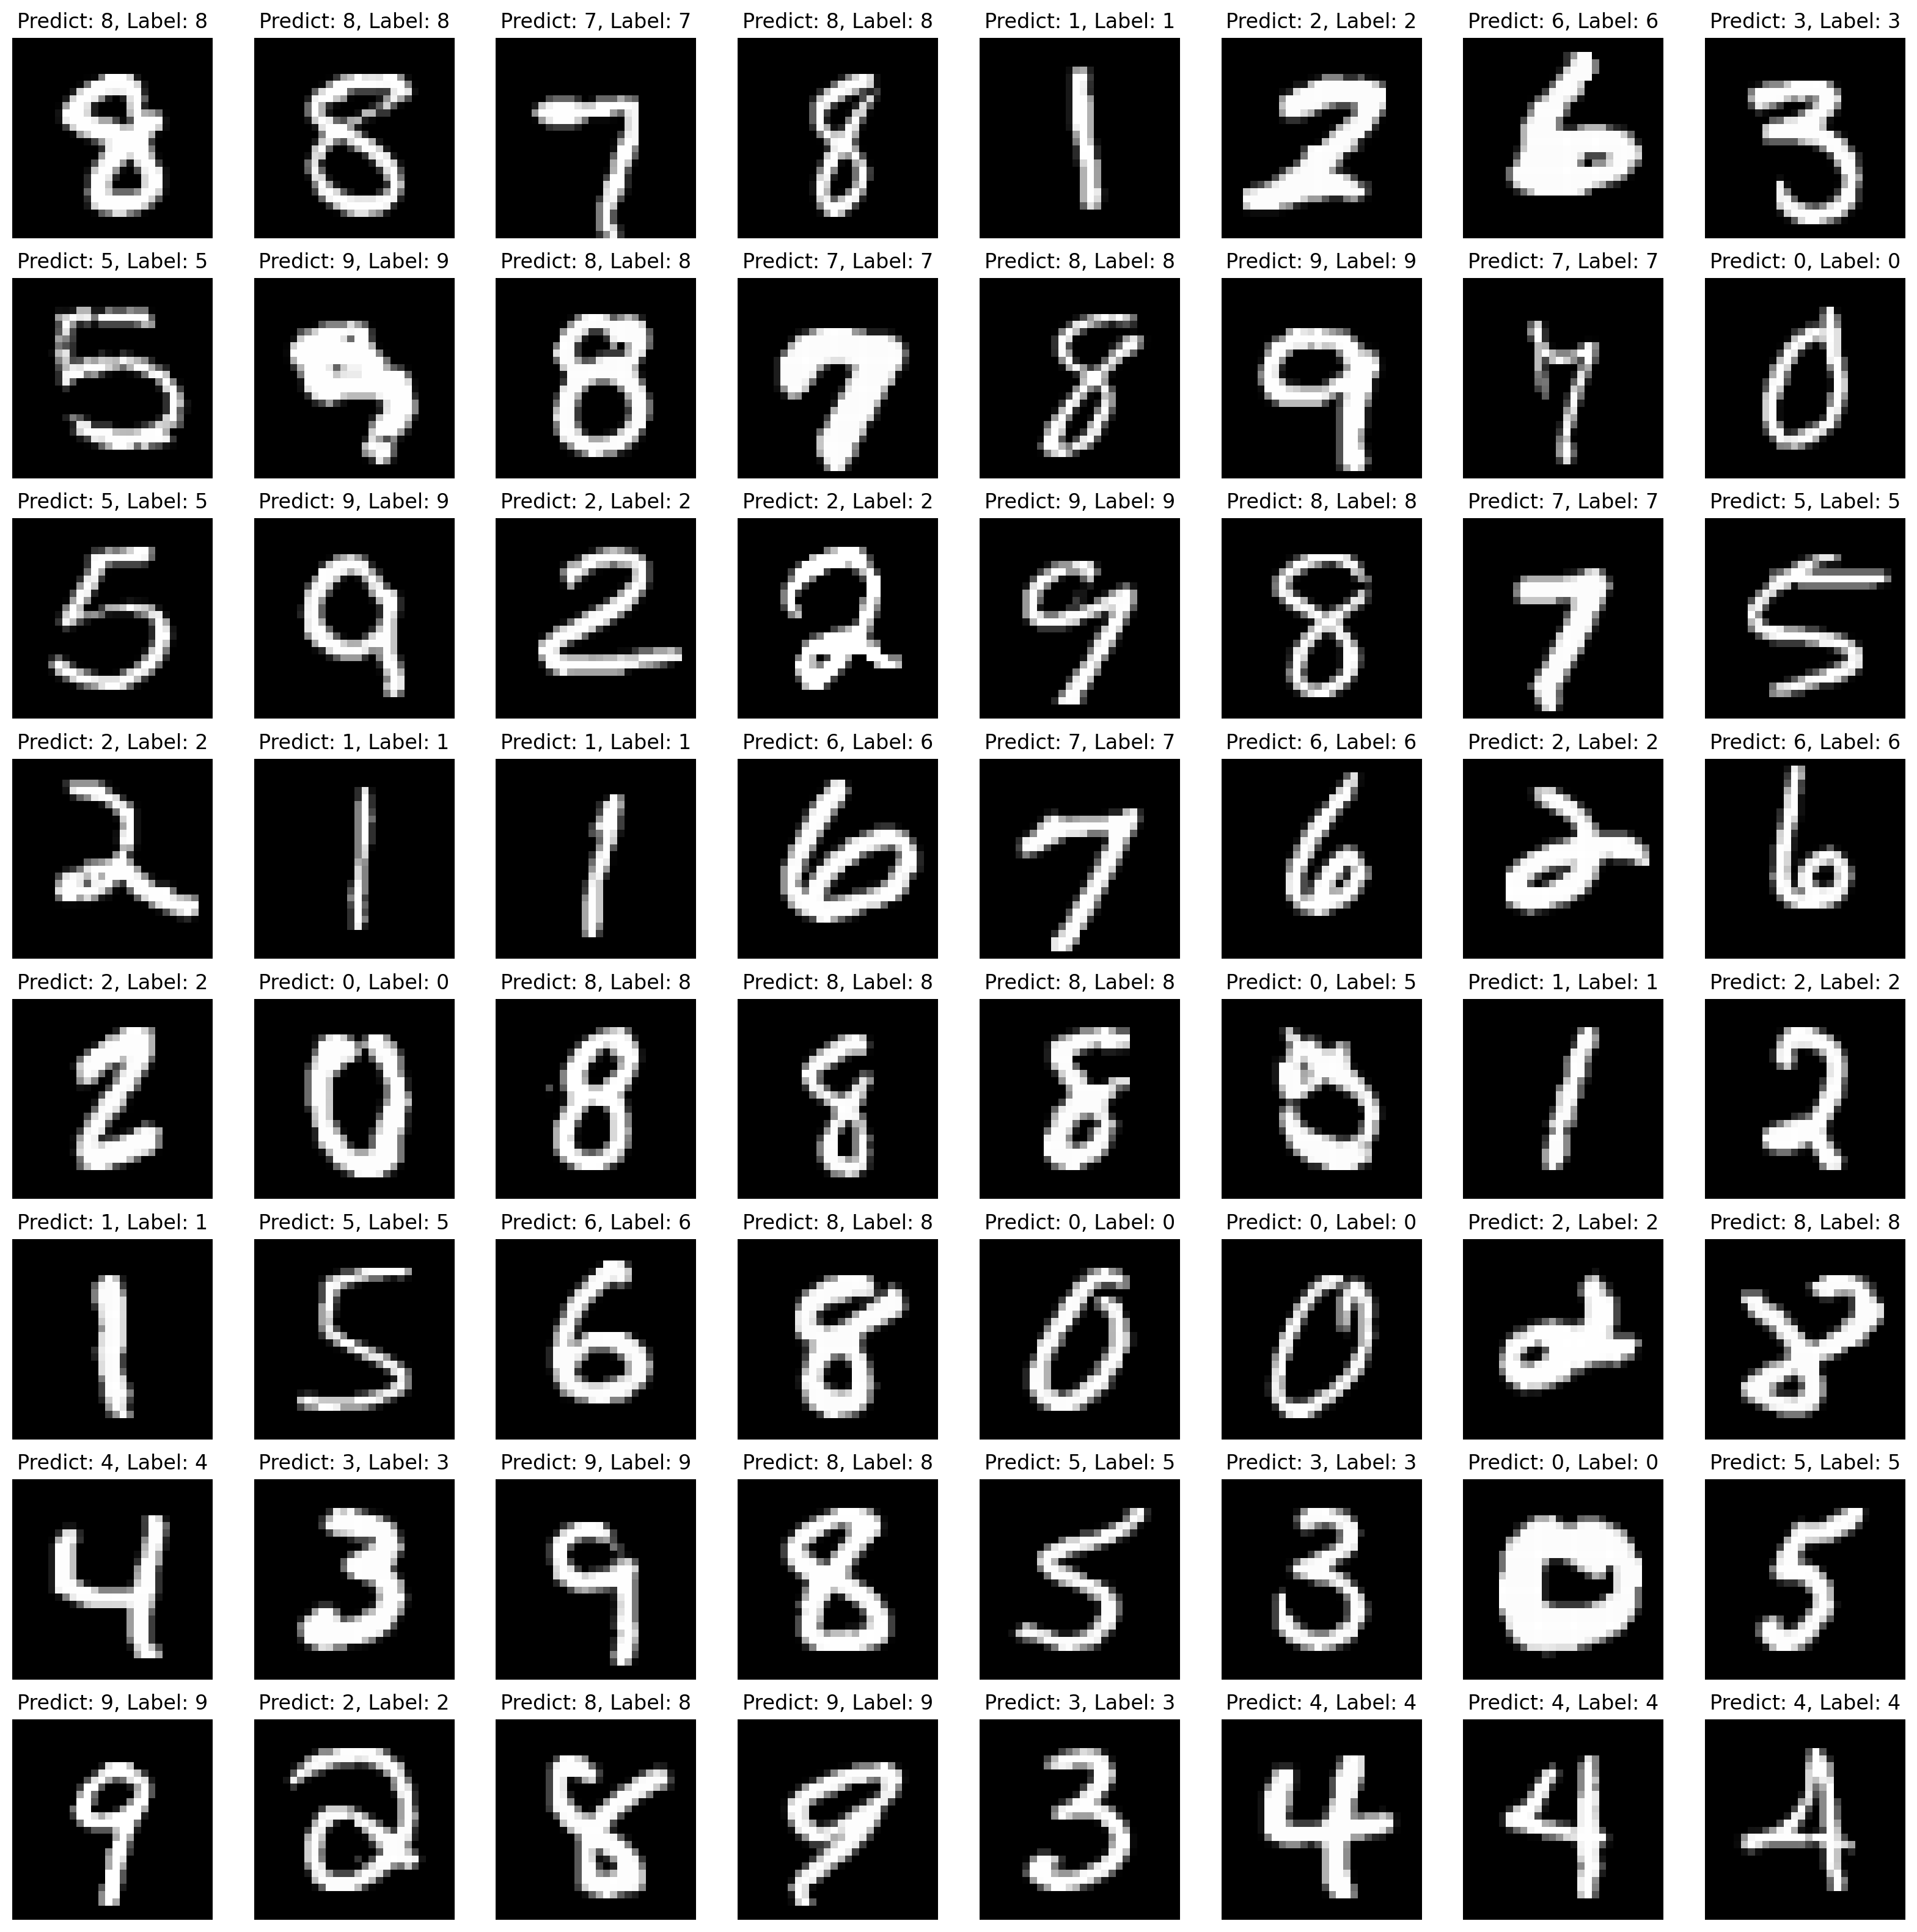

In [11]:
#model.eval()

n_sample = 64

sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace = False)

test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():

    y_pred = model.forward(test_x.view(-1, 28*28).type(torch.float).to(device))

y_pred = y_pred.argmax(axis = 1)

plt.figure(figsize = (20, 20))

for idx in range(n_sample):

    plt.subplot(8, 8, idx+1)
    plt.imshow(test_x[idx], cmap = 'gray')
    plt.axis('off')
    plt.title(f'Predict: {y_pred[idx]}, Label: {test_y[idx]}')

plt.show()